# Demo - Evaluation - Siren (PyTorch)

In [1]:
import sys, os
from pyprojroot import here


# spyder up to find the root, local
root = here(project_files=[".root"])
local = here(project_files=[".local"])

# append to path
sys.path.append(str(root))
sys.path.append(str(local))

In [2]:
from pathlib import Path
import argparse
import wandb
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import loguru
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

# # Ensure TF does not see GPU and grab all GPU memory.
# import tensorflow as tf
# tf.config.set_visible_devices([], device_type='GPU')

# os.environ["JAX_PLATFORM_NAME"] = "CPU"
# # ENSURE JAX DOESNT PREALLOCATE
# os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = str(False)

from ml4ssh._src.io import load_object, save_object
from ml4ssh._src.viz import create_movie, plot_psd_spectrum, plot_psd_score
from ml4ssh._src.utils import get_meshgrid, calculate_gradient, calculate_laplacian

# import parsers
from data import get_data_args, load_data
from preprocess import add_preprocess_args, preprocess_data
from features import add_feature_args, feature_transform
from split import add_split_args, split_data
from models.siren_torch import add_model_args
from loss import add_loss_args, get_loss_fn
from logger import add_logger_args
from optimizer import add_optimizer_args, get_optimizer
from postprocess import add_postprocess_args, postprocess_data, generate_eval_data
from evaluation import add_eval_args, get_rmse_metrics, get_psd_metrics

from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import Trainer
from pytorch_lightning.utilities.argparse import add_argparse_args

%matplotlib inline
%load_ext autoreload
%autoreload 2

### Arguments

In [76]:
# ==========
# RESNET
# ==========
# ige/nerf4ssh/2n5229bh # epoch=536-step=211578.ckpt
# ige/nerf4ssh/32irxqm4 # epoch=373-step=147356.ckpt
# ige/nerf4ssh/2otokg6o # epoch=453-step=178876.ckpt
# ===============
# STANDARD (128)
# ===============
# ige/nerf4ssh/flez78a6 # epoch=2519-step=992880.ckpt # copy-cabra
# ===============
# STANDARD (512)
# ===============
# ige/nerf4ssh/3jxcg0xh # 
# ige/nerf4ssh/3iuwfu5h # epoch=2674-step=1053950.ckpt # dutiful sea ( 2 layers )
# ige/nerf4ssh/3d4rerfr # epoch=1171-step=461768.ckpt # avid-cloud (3 layers)
# ige/nerf4ssh/akq2iv1z # epoch=1095-step=431824.ckpt # icy-plant (4 layers)
# ige/nerf4ssh/2wbe5r2u * epoch=871-step=343568.ckpt # fiery-sunset ( 5 layers )
# ige/nerf4ssh/24kiuvw8 # epoch=536-step=211578.ckpt # apricot-field (6 layers)
# ige/nerf4ssh/1vijztr6 # epoch=453-step=178876.ckpt # fancy-wave (7 layers)
# ige/nerf4ssh/3l7fe7v4 # epoch=373-step=147356.ckpt # fine-microwave (8 layers)
# ige/nerf4ssh/3lbjqm1a # epoch=372-step=146962.ckpt # legendary-dream (9 layers)


wandb_id = "akq2iv1z"
entity = "ige"
project = "nerf4ssh"
resume = True
mode = "online"
checkpoint_name = "epoch=1095-step=431824.ckpt"

### Logger


In [77]:
# init wandb logger
wandb_logger = WandbLogger(
    id=wandb_id,
    mode=mode,
    project=project,
    entity=entity,
    resume=resume,
)

/home/johnsonj/miniconda3/envs/jaxtftorch_cpu_py39/lib/python3.9/site-packages/pytorch_lightning/loggers/wandb.py:347: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


In [78]:
args = wandb_logger.experiment.config

In [79]:
args.train_data_dir = "/home/johnsonj/data/dc_2021/raw/train"
args.ref_data_dir = "/home/johnsonj/data/dc_2021/raw/ref"
args.test_data_dir = "/home/johnsonj/data/dc_2021/raw/test"

### Load Data

In [80]:
%%time

# load data
data = load_data(args)

100%|██████████| 6/6 [00:00<00:00, 41.94it/s]


CPU times: user 1.15 s, sys: 1.7 s, total: 2.85 s
Wall time: 2.87 s


In [81]:
# preprocess data
data = preprocess_data(data, args)

In [82]:
data[data.attrs["input_cols"]].describe()

,longitude,latitude
count,1.790094e+06,1.790094e+06
mean,3.014897e+02,3.581542e+01
std,8.457194e+00,7.822792e+00
min,2.850000e+02,2.300002e+01
25%,2.945217e+02,2.922090e+01
50%,3.019900e+02,3.538647e+01
75%,3.089025e+02,4.169575e+01
max,3.150000e+02,5.299990e+01


In [83]:
# feature transformation
data, scaler = feature_transform(data, args)

In [84]:
data.attrs["input_cols"]

['longitude', 'latitude', 'time']

In [85]:
data[data.attrs["input_cols"]].describe()

,longitude,latitude,time
count,1.790094e+06,1.790094e+06,1.790094e+06
mean,9.931211e-02,-1.456369e-01,-2.934260e-02
std,5.638133e-01,5.215216e-01,5.806831e-01
min,-1.000000e+00,-1.000000e+00,-1.000000e+00
25%,-3.652177e-01,-5.852729e-01,-5.627976e-01
50%,1.326643e-01,-1.742332e-01,1.634461e-04
75%,5.935011e-01,2.463873e-01,4.528359e-01
max,1.000000e+00,1.000000e+00,1.000000e+00


In [86]:
scaler.data_max_, scaler.data_min_

(array([3.14999995e+02, 5.29998990e+01, 2.45814946e+06]),
 array([2.85000013e+02, 2.30000210e+01, 2.45772355e+06]))

In [87]:
# split data
xtrain, ytrain, xvalid, yvalid = split_data(data, args)

args.in_dim = xtrain.shape[-1]
args.n_train = xtrain.shape[0]
args.n_valid = xvalid.shape[0]

wandb_logger.log_hyperparams(
    {
        "in_dim": args.in_dim,
        "n_train": args.n_train,
        "n_valid": args.n_valid,
    }
)

In [88]:
args.n_train, args.n_valid

(1611084, 179010)

In [89]:
data[data.attrs["input_cols"]].describe()

,longitude,latitude,time
count,1.790094e+06,1.790094e+06,1.790094e+06
mean,9.931211e-02,-1.456369e-01,-2.934260e-02
std,5.638133e-01,5.215216e-01,5.806831e-01
min,-1.000000e+00,-1.000000e+00,-1.000000e+00
25%,-3.652177e-01,-5.852729e-01,-5.627976e-01
50%,1.326643e-01,-1.742332e-01,1.634461e-04
75%,5.935011e-01,2.463873e-01,4.528359e-01
max,1.000000e+00,1.000000e+00,1.000000e+00


### Dataset

In [90]:
import torch
from torch.utils.data import Dataset, DataLoader

In [91]:
class PointsDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        X = self.X[index]
        y = self.y[index]
        
        return X, y

In [92]:
# initialize dataset
ds_train = PointsDataset(torch.Tensor(xtrain), torch.Tensor(ytrain))
ds_valid = PointsDataset(torch.Tensor(xvalid), torch.Tensor(yvalid))
# initialize dataloader
# initialize dataloader
dl_train = DataLoader(
    ds_train, 
    batch_size=args.batch_size, 
    shuffle=True, 
    pin_memory=True,
    num_workers=0#args.num_workers
)
dl_valid = DataLoader(
    ds_valid, 
    batch_size=args.batch_size, 
    shuffle=False, 
    pin_memory=True,
    num_workers=0#args.num_workers,
)

### Model

In [93]:
from ml4ssh._src.models_torch.siren import SirenNet

In [94]:
model = SirenNet(
    dim_in=3,
    dim_hidden=args.hidden_dim,
    dim_out=ytrain.shape[1], 
    num_layers=args.n_hidden, 
    w0=args.w0,
    w0_initial=args.w0_initial,
    use_bias=True,
    final_activation=None
)
    

### Training

In [95]:
import torch
from torch import nn


In [96]:
import pytorch_lightning as pl

class LearnerPoints(pl.LightningModule):
    def __init__(self, model:nn.Module):
        super().__init__()
        self.model = model
        self.loss = nn.MSELoss(reduction="mean")

    def forward(self, x):
        return self.model(x)
    
    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        
        
        x, y = batch
        pred = self.model(x)
        
        return pred

    def training_step(self, batch, batch_idx):
        x, y = batch
        # loss function
        pred = self.model(x)
        loss = self.loss(pred, y)
        
        self.log("train_loss", loss)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        # loss function
        pred = self.model(x)
        loss = self.loss(pred, y)
        
        self.log("valid_loss", loss)
        
        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=args.learning_rate)

In [97]:
# initialize trainer
learn = LearnerPoints(model)

In [98]:
from pytorch_lightning import seed_everything
seed_everything(123)

Global seed set to 123


123

In [99]:
# initialize trainer
trainer = pl.Trainer(
    min_epochs=args.min_epochs, 
    max_epochs=args.n_epochs, 
    gpus=0, 
    enable_progress_bar=True, 
    logger=wandb_logger,
    # callbacks=callbacks,
)

Multiprocessing is handled by SLURM.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


## Load Models

In [100]:
# if args.server == "jz":
# get id (from this run or a run you can set)
run_id = wandb.run.id

# initialize api
api = wandb.Api()

# get run
run = api.run(f"{args.entity}/{args.project}/{run_id}")

# download the files
files = [
    "scaler.pickle", 
    f"checkpoints/{checkpoint_name}"
    # "checkpoints/last.ckpt"
]

for ifile in files:
    
    run.file(ifile).download(replace=True)

CommError: Permission denied to access ige/nerf4ssh/2wbe5r2u

In [ ]:

scaler = load_object("./scaler.pickle")

In [ ]:
learn = LearnerPoints.load_from_checkpoint(
    checkpoint_path=f"checkpoints/{checkpoint_name}",
    model=model
)

### PostProcessing

In [ ]:
args.eval_dlon = 0.1
args.eval_dlat = 0.1

In [ ]:
df_grid = generate_eval_data(args)

df_grid.describe()

In [ ]:
df_pred = feature_transform(df_grid.copy(), args, scaler=scaler)
# df_pred.describe()

In [ ]:
df_pred.describe()

In [ ]:
df_pred = df_pred[df_pred.attrs["input_cols"]].values

In [ ]:
# initialize dataset
ds_test = PointsDataset(torch.Tensor(df_pred), torch.Tensor(df_pred))
# initialize dataloader
dl_test = DataLoader(
    ds_test,
    batch_size=args.eval_batch_size,
    shuffle=False,
    pin_memory=True
)

In [ ]:
%%time

predictions = trainer.predict(learn, dataloaders=dl_test, return_predictions=True)


In [ ]:
predictions = torch.cat(predictions)

In [ ]:
df_grid["pred"] = predictions.numpy()

In [ ]:
wandb_logger.log_hyperparams(
    {
        "n_test": df_pred.shape[0],
    }
)

In [ ]:
ds_oi = postprocess_data(df_grid, args)

In [ ]:
ds_oi

In [ ]:
%%time

rmse_metrics = get_rmse_metrics(ds_oi, args)

wandb_logger.log_metrics(
    {
        "model_rmse_mean": rmse_metrics[0],
        "model_rmse_std": rmse_metrics[1],
        "model_nrmse_mean": rmse_metrics[2],
        "model_nrmse_std": rmse_metrics[3],
    }
)

print(rmse_metrics)

In [101]:
psd_metrics = get_psd_metrics(ds_oi, args)
print(psd_metrics)

wandb_logger.log_metrics(
    {
        "resolved_scale": psd_metrics.resolved_scale,
    }
)

Resolved Scale: 152.374 (km)


### Figures

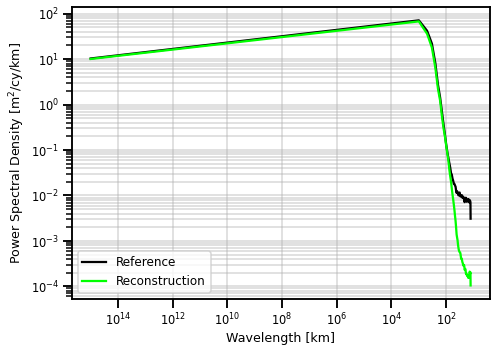

In [102]:
fig, ax = plot_psd_spectrum(
    psd_metrics.psd_study, 
    psd_metrics.psd_ref, 
    psd_metrics.wavenumber
)


wandb_logger.experiment.log(
    {
        "model_psd_spectrum": wandb.Image(fig),
    }
)

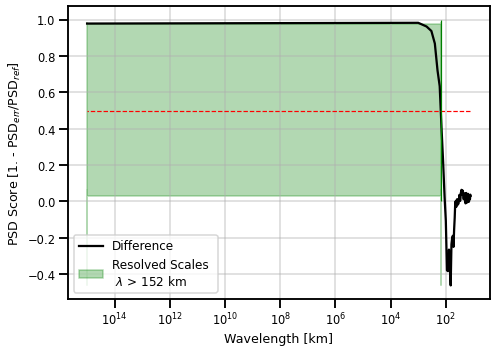

In [103]:
fig, ax = plot_psd_score(
    psd_metrics.psd_diff, 
    psd_metrics.psd_ref, 
    psd_metrics.wavenumber, 
    psd_metrics.resolved_scale)

wandb_logger.experiment.log(
    {
        "model_psd_score": wandb.Image(fig),
    }
)

### Movies

In [104]:
save_path = wandb.run.dir #Path(root).joinpath("experiments/dc_2021b")

In [105]:
import hvplot.xarray


ds_oi.ssh.hvplot.image(
    x="longitude",
    y="latitude",
    # groupby='time',
    # rasterize=True, 
    width=500, height=400, cmap="viridis")

:DynamicMap   [time]
   :Image   [longitude,latitude]   (ssh)

In [106]:
# create_movie(ds_oi.ssh.isel(time=slice(50,60)), f"pred", "time", cmap="viridis", file_path=save_path)

<!-- ![](wandb/run-20220601_174733-kx2nr6qb/files/movie_pred.gif) -->

In [107]:
# if args.smoke_test:
#     create_movie(ds_oi.ssh.isel(time=slice(50,60)), f"pred", "time", cmap="viridis", file_path=save_path)
# else:
#     create_movie(ds_oi.ssh, f"pred", "time", cmap="viridis", file_path=save_path)


In [108]:
# wandb.log(
#     {
#         "predictions_gif": wandb.Image(f"{save_path}/movie_pred.gif"),
#     }
# )

### Gradients

In [109]:
ds_oi["ssh_grad"] = calculate_gradient(ds_oi["ssh"], "longitude", "latitude")

In [110]:
ds_oi.ssh_grad.hvplot.image(
    x="longitude",
    y="latitude",
    # groupby='time',
    # rasterize=True, 
    width=500, height=400, cmap="Spectral_r")

:DynamicMap   [time]
   :Image   [longitude,latitude]   (ssh_grad)

In [111]:
# if args.smoke_test:
#     create_movie(ds_oi.ssh_grad.isel(time=slice(50,60)), f"pred_grad", "time", cmap="Spectral_r", file_path=save_path)
# else:
#     create_movie(ds_oi.ssh_grad, f"pred_grad", "time", cmap="Spectral_r", file_path=save_path)

In [112]:
# wandb.log(
#     {
#         "predictions_grad_gif": wandb.Image(f"{save_path}/movie_pred_grad.gif"),
#     }
# )

### Laplacian

In [113]:
ds_oi["ssh_lap"] = calculate_laplacian(ds_oi["ssh"], "longitude", "latitude")

In [114]:
ds_oi.ssh_lap.hvplot.image(
    x="longitude",
    y="latitude",
    # groupby='time',
    # rasterize=True, 
    width=500, height=400, cmap="RdBu_r")

:DynamicMap   [time]
   :Image   [longitude,latitude]   (ssh_lap)

In [115]:
# if args.smoke_test:
#     create_movie(ds_oi.ssh_lap.isel(time=slice(50,60)), f"pred_lap", "time", cmap="RdBu_r", file_path=save_path)
# else:
#     create_movie(ds_oi.ssh_lap, f"pred_lap", "time", cmap="RdBu_r", file_path=save_path)


In [116]:
# wandb.log(
#     {
#         "predictions_laplacian_gif": wandb.Image(f"{save_path}/movie_pred_lap.gif"),
#     }
# )

In [117]:
wandb_logger.experiment.finish()

model_nrmse_mean,█▁
model_nrmse_std,▁█
model_rmse_mean,▁█
model_rmse_std,█▁
resolved_scale,▁██
epoch,1171
model_nrmse_mean,0.8642
model_nrmse_std,0.08705
model_rmse_mean,0.07897
model_rmse_std,0.02442
resolved_scale,152.37413
